## check gammapy version

In [1]:
import gammapy
gammapy.__version__

'1.0.1'

## some imports

In [2]:
import os
import glob

In [3]:
from astropy import units as u

from astropy.coordinates import SkyCoord, Angle

## set position, search radius and data location

The next line points to the location of the data files. It should point to a directory where the different configurations are saved in sub-directories.

In [4]:
basepath = 'C:/Users/User 1/Desktop/Honours Project/Data'

The next cell defines the source position and the search radius.

In [5]:
sourcepos = SkyCoord(83.633, 22.014, unit="deg", frame='icrs')

selectradius = 2.5*u.deg

## select the analysis configuration

The following cell lists all available configurations with their respective number.

In [6]:
analysis_configs = os.listdir(basepath)

c = 0

for i in analysis_configs :

    print('{}. {}'.format(c, i))
    
    c+=1

0. ModelPlus_HESSI_Stereo_Faint
1. ModelPlus_HESSI_Stereo_Std
2. ModelPlus_HESS_Combined_Stereo_Faint
3. ModelPlus_HESS_Combined_Stereo_Std


Choose a selection and put the number in the next cell. Note that the numbers may change when more configurations are added.

In [7]:
conf = analysis_configs[3]

In [8]:
print('You have chosen configuration {}.'.format(conf))

You have chosen configuration ModelPlus_HESS_Combined_Stereo_Std.


## cone search, run list and preparation of observations

In [9]:
os.environ['HESS_FITS'] = basepath

In [10]:
path = os.path.join(basepath, conf)

In [11]:
from gammapy.data import DataStore

In [12]:
data_store = DataStore.from_dir(path)

In [13]:
conesearch = data_store.obs_table.select_sky_circle(sourcepos, selectradius)

In [14]:
import numpy as np

The runs have different telescope configurations. Each number stands for one telescpe, 1 - 4 being the small telescopes and 5 the large telescope:

In [15]:
np.unique(conesearch['TELLIST'])

"1,2,3,4,5"


We want only the runs containing all telescopes:

In [16]:
telsearch = conesearch[conesearch['TELLIST'] == '1,2,3,4,5']

In [17]:
runlist = telsearch['OBS_ID'].value

The run list is:

In [18]:
print(runlist)

[ 88973  88986  88951  88952  82725  82782  90408  90564  90439  90478
  90415  90441  90410  90437  90440 135629 135635 135667 135666 135634
 135665 103805 103806 103849 103851 103848 103957 103850 103847 103956
 103803 103804 101451  79556 143050 143161 143136 143137 143165 143134
 143082 143135 135520 135482 135481 135479 135480 135521 135271 135306
 135307 135247 135246 135272 135333 135270 135273 125794 125719 125716
 125793 125757 125715 125717 142897 142990 142989 142896 102987 102988
  82038 136480  89732 126535 126538 126540 126536  79858  79862  79884
  79882  79860  79885  79859  79881  90317  90350  90319  90277  90239
  90203  90380  90275  90321  90318  90352  90381  90382  90237  90376
  90377  90276  90378  90351  90320  90278  90238  90349  90379  90348
 102576 102575 102402 101135 101071 101166 103698 103737 103697 103738
 143211 143212 143210 143213 142428 142510 142593 142463 142427 142565
 142592 142566 142530 142462 142567 142460 142588 142430 142594 142464
 14256

Now we get the observations for these runs:

In [19]:
observations = data_store.get_observations(runlist)

## Analysis

In [20]:
import matplotlib.pyplot as plt
from IPython.display import display
from regions import CircleSkyRegion
import scipy.stats

from gammapy.makers import MapDatasetMaker, FoVBackgroundMaker
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
)

from gammapy.estimators import (
    ExcessMapEstimator,
    FluxPointsEstimator,
)

from gammapy.maps import Map, WcsGeom, WcsNDMap, RegionGeom, MapAxis
from gammapy.datasets import MapDatasetOnOff
from gammapy.datasets import MapDataset
from gammapy.data import EventList
from gammapy.modeling import Fit
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)

from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [21]:
#Selecting the region of interest
on_region = CircleSkyRegion(center=sourcepos, radius=Angle("0.65 deg"))

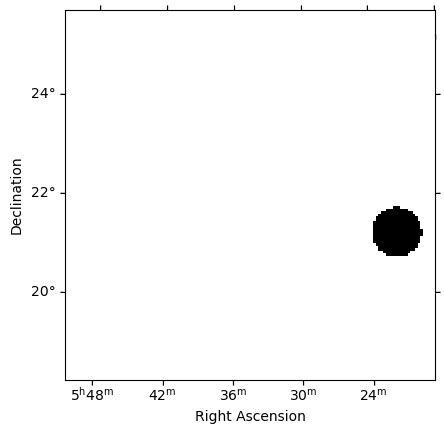

In [22]:
#We Create the exclusion mask
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = sourcepos.galactic
geom = WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot()
plt.show()

In [23]:
#We create the configuration of the maker classes
energy_axis = MapAxis.from_energy_bounds(
    0.1, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

#We create a spectrum dataset
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [24]:
datasets = Datasets()

for obs_id, observation in zip(runlist, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

print(datasets)

C:\Users\User 1\anaconda3.1\envs\gammapy-1.0.1\lib\site-packages\gammapy\maps\geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
HDU 'PSF' not found


AttributeError: 'NoneType' object has no attribute 'containment'